In [22]:
#!/usr/bin/python
# -*- coding: UTF-8 -*-
 
import smtplib
from email.mime.text import MIMEText
from email.utils import formataddr
 
my_sender='2325368641@qq.com'    # 发件人邮箱账号
my_pass = 'gnjndmbpxdteeafi'              # 发件人邮箱密码
my_user='2325368641@qq.com'      # 收件人邮箱账号，我这边发送给自己
def mail():
    ret=True
    try:
        msg=MIMEText('填写邮件内容','plain','utf-8')
        msg['From']=formataddr(["FromRunoob",my_sender])  # 括号里的对应发件人邮箱昵称、发件人邮箱账号
        msg['To']=formataddr(["FK",my_user])              # 括号里的对应收件人邮箱昵称、收件人邮箱账号
        msg['Subject']="菜鸟教程发送邮件测试"                # 邮件的主题，也可以说是标题
 
        server=smtplib.SMTP_SSL("smtp.qq.com", 465)  # 发件人邮箱中的SMTP服务器，端口是25
        server.login(my_sender, my_pass)  # 括号中对应的是发件人邮箱账号、邮箱密码
        server.sendmail(my_sender,[my_user,],msg.as_string())  # 括号中对应的是发件人邮箱账号、收件人邮箱账号、发送邮件
        server.quit()  # 关闭连接
    except Exception:  # 如果 try 中的语句没有执行，则会执行下面的 ret=False
        ret=False
    return ret
 
ret=mail()
if ret:
    print("邮件发送成功")
else:
    print("邮件发送失败")

邮件发送成功


In [26]:
import kwant
import kwant.continuum
import numpy as np
import time as ti
from mpi4py import MPI
comm = MPI.COMM_WORLD
k = comm.Get_rank()
nprocessor = comm.size

import warnings
warnings.filterwarnings('ignore')

# Pauli matrices

s0 = np.eye(2)
sx = np.array([[0,1], [1,0]])
sy = np.array([[0, -1j],[1j, 0]])
sz = np.array([[1,0],[0,-1]])

# Parameters

A = 364.5 # meV nm
B = -686 # meV nm^2
C = 0 # meV
D = -512 # meV nm^2
M = -10 # meV

def qwz(a=1, L=20, W=100):
    hamiltonian_syst = """
    (V(x, y) + C-D*(k_x**2+k_y**2))* identity(2)
    + (M-B*(k_x**2+k_y**2)) * sigma_z
    + A*k_x*sigma_x
    + A*k_y*sigma_y
    """
    
    
    hamiltonian_lead = """
    (C-D*(k_x**2+k_y**2))* identity(2)
    + (M-B*(k_x**2+k_y**2)) * sigma_z
    + A*k_x*sigma_x
    + A*k_y*sigma_y
    """
    
    template_syst = kwant.continuum.discretize(hamiltonian_syst, grid=a)
    template_lead = kwant.continuum.discretize(hamiltonian_lead, grid=a)
    
    def shape(site):
        (x, y) = site.pos
        return (0 <= y < W and 0 <= x < L)
    
    def lead_shape(site):
        (x, y) = site.pos
        return (0 <= y < W)
    
    syst = kwant.Builder()
    syst.fill(template_syst, shape, (0, 0))
    
    lead = kwant.Builder(kwant.TranslationalSymmetry([-a, 0]))
    lead.fill(template_lead, lead_shape, (0, 0))
    
    syst.attach_lead(lead)
    syst.attach_lead(lead.reversed())
    
    # kwant.plot(syst)
    syst = syst.finalized()

    return syst

def get_conductance(w, Ef, Nc): # w is the disorder strength, Ef is the Fermi energy, and Nc is the cycling times
    
    def disorder(x, y): # onsite disorder
        return np.random.uniform(-w/2, w/2)

    params = dict(A = A, B = B, C = C, D = D, M = M, Ef = Ef, V = disorder)
    syst = qwz()
    data = []
    
    for i in range(Nc):
        smatrix = kwant.smatrix(syst, Ef, params = params)
        data.append(smatrix.transmission(1, 0))
        
    G_av = np.mean(data)
    G_std = np.std(data)
    
    return G_av, G_std


def main():
    t1 = ti.time()
    syst = qwz()
    Ef = 5 # meV
    Nc = 200 # cycle
    w = k * 0.5 # meV
    G_av, G_std = get_conductance(w, Ef, Nc)
    # pyplot.plot(energies, data)
    # pyplot.xlabel("energy [t]")
    # pyplot.ylabel("conductance [e^2/h]")
    # pyplot.show()
    # pyplot.savefig('conductance' +str(k)+ '.png')
    # np.savez('cond'+str(k)+ '.npz', x = w, y = G_av, ye = G_std)
    print('Disorder strength:', w, 'Average conductance:', G_av, 'Conductance fluctuation:', G_std)
    t2 = ti.time()
    print('time cost:', t2-t1, 's')


if __name__ == '__main__':
    main()

Disorder strength: 0.0 Average conductance: 1.0000000000000424 Conductance fluctuation: 2.220446049250313e-16
time cost: 467.2010259628296 s


## 1建立系统

In [ ]:
import kwant
import kwant.continuum
import scipy.sparse.linalg
import scipy.linalg
import numpy as np
from numpy import pi

# For plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'Times New Roman'

In [29]:
def make_system(a = 1, t = 1, L = 10): # a = 1为晶格常数, L, W 为长宽

    lat = kwant.lattice.square(a)  # 创建2D正方晶格

    syst = kwant.Builder(kwant.TranslationalSymmetry([0, a]))  # 建立中心体系，利用平移对称性使y方向为无穷大，可视为周期边界

    # 中心区
    syst[(lat(x, 0) for x in range(L))] = 0 # on-site能量为0
    syst[lat.neighbors()] = -t  # 用neighbors()指定最近邻跃迁
    
    kwant.plot(syst, dpi=300)  # 系统示意图，通过图像可以看出有没有写错
    syst = syst.finalized()  # 结束体系的制作。这个语句不可以省。这个语句是把Builder对象转换成可计算的对象。
    return syst


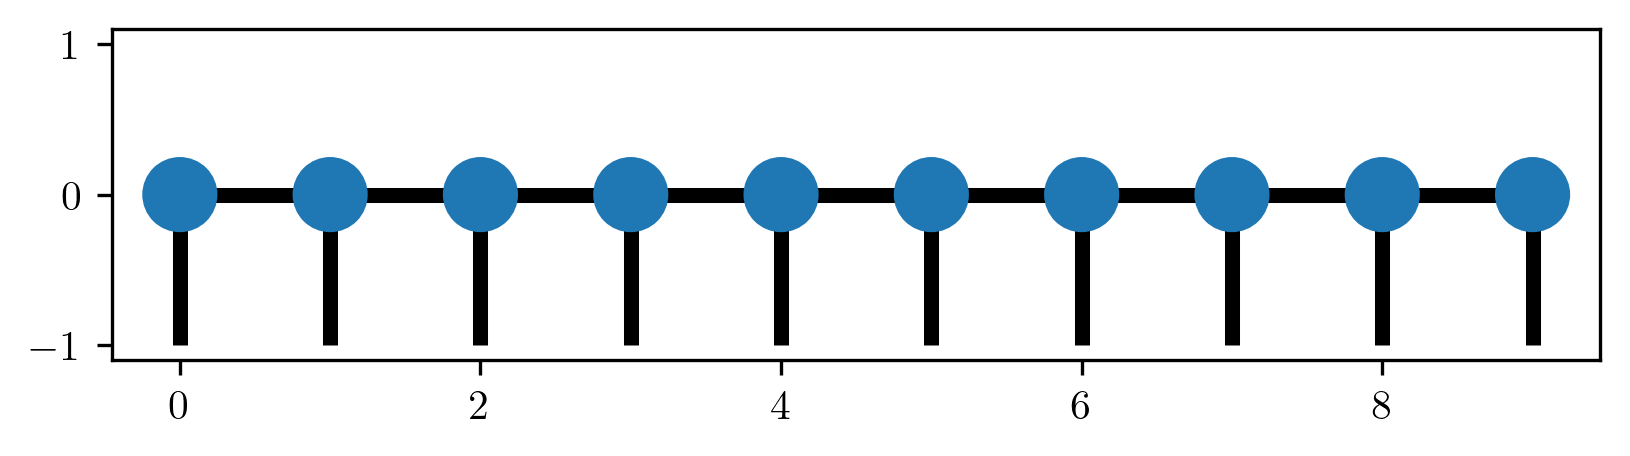

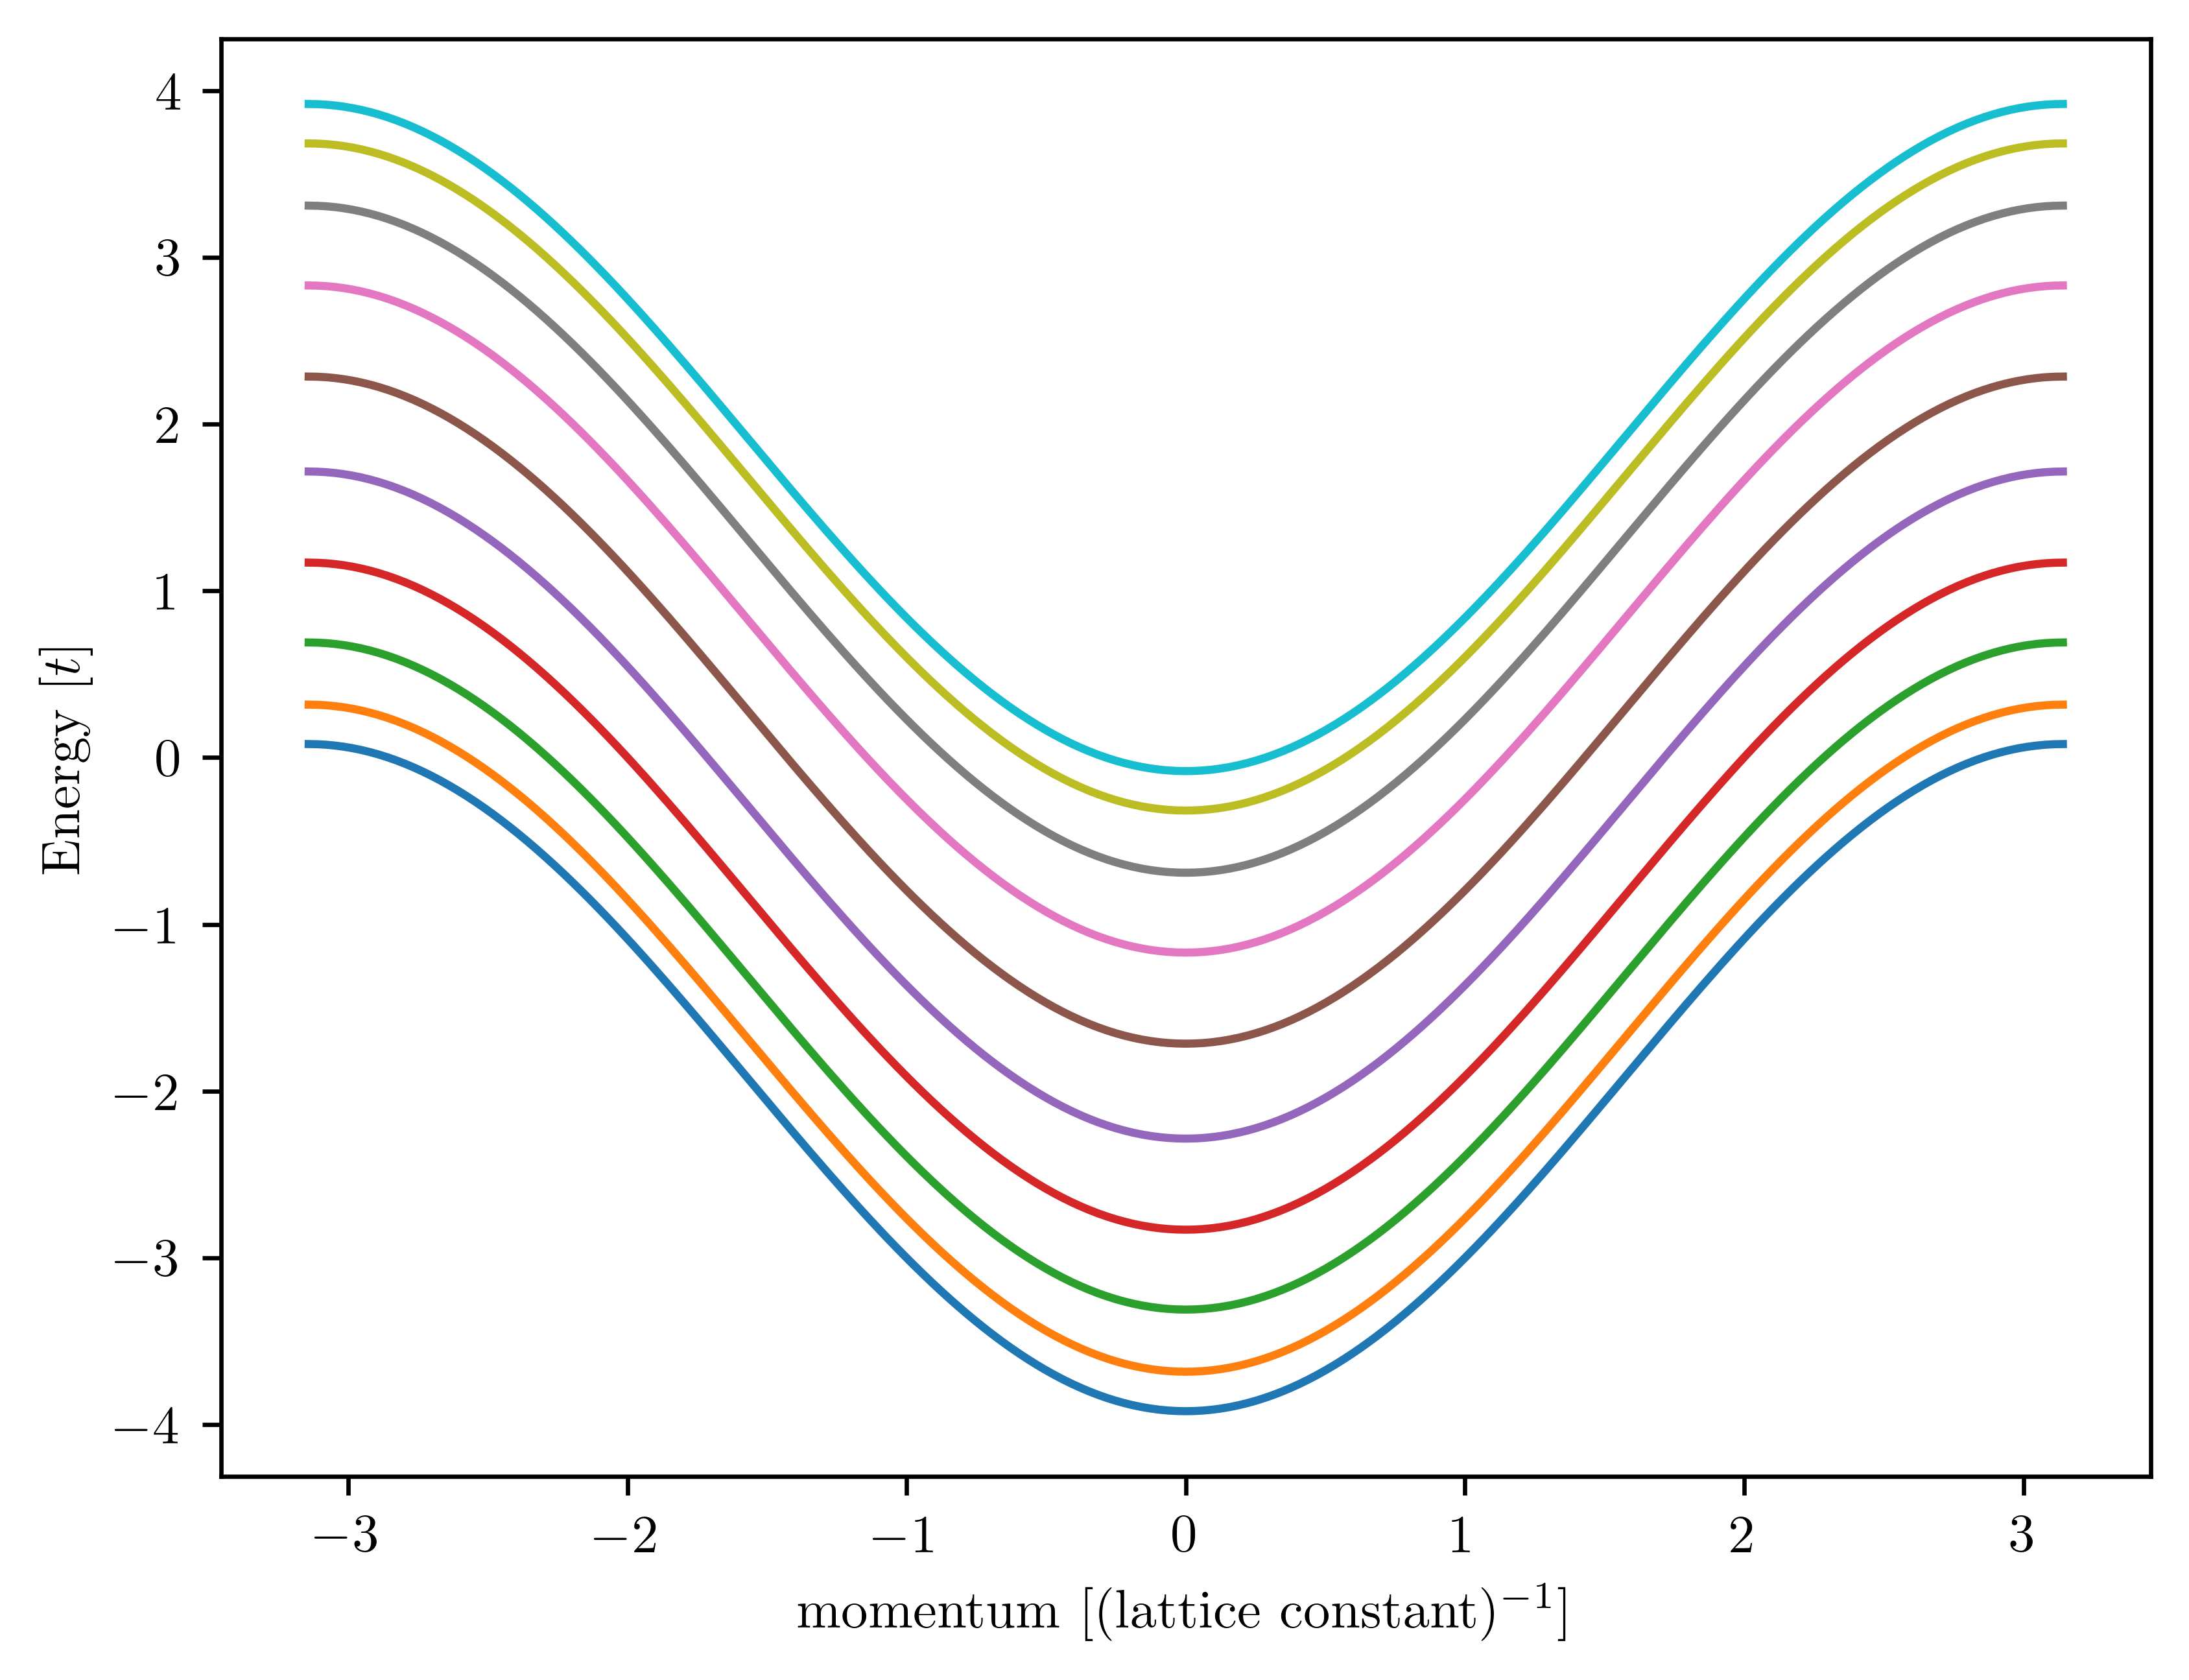

In [30]:
kwant.plotter.bands(make_system(), momenta=np.linspace(-pi, pi, 201), show=False, dpi=600)
plt.xlabel("momentum [(lattice constant)$^{-1}$]")
plt.ylabel("Energy [$t$]")
plt.show()

In [31]:
# Pauli Matrices
s0 = np.eye(2)
sx = np.array([[0,1], [1,0]])
sy = np.array([[0, -1j],[1j, 0]])
sz = np.array([[1,0],[0,-1]])

In [32]:
def qwz(a = 1, m=-1.6, L = 20): # a = 1为晶格常数, L, W 为长宽

    lat = kwant.lattice.square(a)  # 创建晶格，方格子

    syst = kwant.Builder(kwant.TranslationalSymmetry([0, a]))  # 建立中心体系

    # 中心区
    syst[(lat(x, 0) for x in range(L))] = m * sz # onsite能是矩阵也可以被Builder识别
    syst[kwant.builder.HoppingKind((1, 0), lat, lat)] = 0.5 * (sz - 1j * sx) #
    syst[kwant.builder.HoppingKind((0, 1), lat, lat)] = 0.5 * (sz - 1j * sy)
    
    kwant.plot(syst, dpi=300)  # 把电极-中心区-电极图画出来，通过图像可以看出有没有写错
    syst = syst.finalized()  # 结束体系的制作。这个语句不可以省。这个语句是把Builder对象转换成可计算的对象。
    return syst

In [27]:
import numpy as np
import os

for L in [16,32,64]:
# for L in size_list:
    x1 = []
    y1 = []
    y1e = []
    
    for k in range(50): # 50个无序构型
        with np.load('cond('+str(L)+')'+str(k)+ '.npz') as data1: # 载入文件，结束后退出载入
            x1.append(data1['x']) # 无序强度
            y1.append(data1['y']) # 平均电导
            y1e.append(data1['ye']) # 标准差
        os.remove('cond('+str(L)+')'+str(k)+ '.npz') # 删除文件，最后只保留一个汇总的npz文件
    np.savez('cond('+str(L)+')'+'.npz', x = x1, y = y1, ye = y1e) # 保存为对应格点数的npz文件

FileNotFoundError: [Errno 2] No such file or directory: 'cond(16)0.npz'